# (1.) Autoencoder อย่างง่าย

สร้าง Autoencoder อย่างง่าย ข้อมูลที่ใช้คือ Fashion MNIST ประกอบด้วยภาพเสื้อ รองเท้า กระเป๋า ... ขนาด 28x28 Pixel ตัวโมเดลไม่ซับซ้อน ใช้เวลา Train บน PC ไม่กี่วินาที

สิ่งที่จะได้จาก workshop นี้คือ
- การสร้าง Autoencoder ทั้งส่วนของ Autoencoder ทั้งส่วน encoder และ decoder
- ข้อมูลที่ผ่านการเข้ารหัสบีบอัดแล้ว (Code, Latent, ...)
- การใช้งาน Autoencoder เบื้องต้น

## Import Data & Library

เริ่มจากอิมพอร์ตและอ่านข้อมูล Fashion MNIST แล้วตรวจสอบขนาดข้อมูลเบื้องต้น จะได้ว่ามีข้อมูล Train จำนวน 60000 samples ข้อมูล Test จำนวน 10000 โดยทั้งหมด มีขนาด 28x28 Pixel ข้อสังเกตเพิ่มเติมคือ Autoencoder จะไม่ได้ใช้ค่า Label (y) เพราะไม่ได้สนใจว่าแต่ละรูปเป็นคลาสอะไร แต่สนใจเฉพาะข้อมูลที่เป็นอินพุต เพื่อนำไปบีบอัดและขยายกลับให้มีขนาดเท่าเดิม ดังนั้นการโหลดอ่านข้อมูลจึงไม่ต้องใช้ค่า y โค้ดอ่านจึงเป็น X_train, _ คือไม่สนใจค่าคลาส (y)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

In [ ]:
(X_train, _), (X_test, _) = fashion_mnist.load_data()
print(X_train.shape)
print(X_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


ข้อมูลภายในคือค่าความสว่างของเม็ด Pixel สามารถตรวจสอบดูข้อมูลบางส่วนได้ โดยเมื่อดูจากค่าข้อมูลที่แสดง จะพอเดาๆได้ว่ารูปลำดับ index 0 คือรูปรองเท้าบูทแบบเตี้ย

In [ ]:
X_train[0][:, 7:20]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0,  13,  73,   0,   0,   1],
       [  0,   0,   0,   0,   0,   3,   0,  36, 136, 127,  62,  54,   0],
       [  0,   0,   0,   0,   0,   6,   0, 102, 204, 176, 134, 144, 123],
       [  0,   0,   0,   0,   0,   0,   0, 155, 236, 207, 178, 107, 156],
       [  0,   0,   0,   0,   1,   0,  69, 207, 223, 218, 216, 216, 163],
       [  0,   0,   1,   1,   1,   0, 200, 232, 232, 233, 229, 223, 223],
       [  0,   0,   0,   0,   0,   0, 183, 225, 216, 223, 228, 235, 227],
       [  0,   0,   0,   0,   0,   0, 193, 228, 218, 213, 198, 180, 212],
       [  0,   0,   1,   3,   0,  12, 219, 220, 212, 218, 192, 169, 227],
       [  0,   0,   0,   6,   0,  99, 244, 222, 220, 218, 203, 198, 221],
       [  0,   0,   4,   0,   0,  55, 

หากต้องการดูรูปภาพข้อมูล ให้ใช้การพล็อต แต่เนื่องจากข้อมูลที่บันทึกเป็นแบบพื้นหลังสีดำ (Inverse) ดังนั้นการพล็อตจึงสั่งกลับภาพ Inverse ตามตัวอย่างข้างล่างนี้

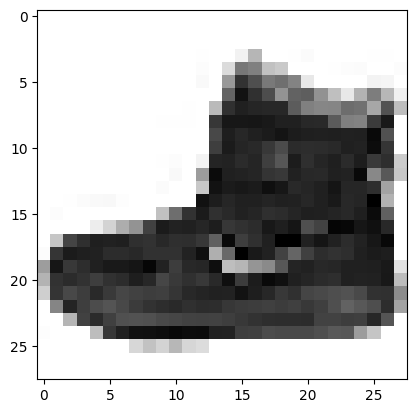

In [ ]:
img = X_train[0]
plt.imshow(img, cmap=plt.cm.gray_r)   # inverse ภาพ
plt.show()

## เตรียมข้อมูล

ข้อมูลภาพเป็นแบบสเกล 0 - 255 ดังนั้นให้ทำการ Normalize ก่อน

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## สร้าง Model

ข้อมูลภาพ Fashion มีขนาด 28x28 ซึ่งคำนวณง่ายๆได้เท่ากับ 787 (Pixel) ตัวอย่างนี้ต้องการมิติข้อมูลที่เข้ารหัสบีบอัดแล้ว (Latent vector) มีค่าเท่ากับ 36 ดังนั้นจึงกำหนดค่าตัวแปร encoding_dim (ขนาด Latent ที่ต้องการ) ไว้ที่ 36

เนื่องจาก Autoencoder แบ่งออกเป็น 2 ส่วนคือ Encoder และ Decoder ที่ทำงานต่อเนื่องกัน การสร้างโมเดลโดยใช้ OOP Class จึงค่อนข้างง่ายกว่าวิธีอื่นๆ เขียนตามโค้ดดังนี้

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras import Model, Sequential

encoding_dm = 36    # ขนาด Latent ที่ต้องการ

class Autoencoder(Model):
  def __init__(self, encoding_dm):
    super(Autoencoder, self).__init__()
    self.encoding_dm = encoding_dm

    # ส่วนของ Encoder
    self.encoder = Sequential([
        # InputLayer(input_shape=(28, 28))    # ไม่มีบรรทัดนี้ก็ได้
        Flatten(),
        Dense(encoding_dm, activation='relu')
    ])

    # ส่วนของ Decoder
    self.decoder = Sequential([
        Dense(784, activation='sigmoid'),
        Reshape((28,28))
    ])
  def call(self, x):
    encoded = self.encoder(x)

    # ข้อมูล Encoder ใช้เป็นอินพุตของ Decoder
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(encoding_dm)    # Instantiate สร้าง Model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=20, batch_size=2256,
                validation_data=(X_test, X_test))

Epoch 1/20
27/27 [==============================] - 6s 159ms/step - loss: 0.6130 - val_loss: 0.5200
Epoch 2/20
27/27 [==============================] - 3s 103ms/step - loss: 0.4769 - val_loss: 0.4367
Epoch 3/20
27/27 [==============================] - 2s 79ms/step - loss: 0.4130 - val_loss: 0.3951
Epoch 4/20
27/27 [==============================] - 2s 89ms/step - loss: 0.3829 - val_loss: 0.3735
Epoch 5/20
27/27 [==============================] - 3s 128ms/step - loss: 0.3633 - val_loss: 0.3557
Epoch 6/20
27/27 [==============================] - 4s 136ms/step - loss: 0.3479 - val_loss: 0.3437
Epoch 7/20
27/27 [==============================] - 3s 93ms/step - loss: 0.3383 - val_loss: 0.3364
Epoch 8/20
27/27 [==============================] - 3s 97ms/step - loss: 0.3321 - val_loss: 0.3315
Epoch 9/20
27/27 [==============================] - 3s 125ms/step - loss: 0.3276 - val_loss: 0.3277
Epoch 10/20
27/27 [==============================] - 4s 161ms/step - loss: 0.3241 - val_loss: 0.3246
Epo

- Encoder: มี input 2 มิติ ขนาด 28x28 (ตามขนาดภาพ Fashion) แปลงให้เป็น 1 มิติ (เป็น vector) โดยใช้ Flatten() จากนั้นต่อด้วย Dense มีขนาดเท่ากับกับขนาด Latent vector ที่ต้องการ ในที่นี้คือขนาด 36 สรุป Model ขั้นตอนนี้ คือ 28x28 -> 784 -> 36
- Decoder: ทำหน้าที่ถอดรหัสโดยรับข้อมูลมาจาก Encoder ซึ่งก็คือ Code หรือ Latent vector ขนาด 36 จากนั้นถอดรหัส Dense 784 แล้วแปลง (Reshape) ให้ได้ข้อมูลมิติเท่ากับอินพุต (Reconstruction) สรุป Model ขั้นตอนนี้ คือ 36 -> 784 -> 28x28

เนื่องจาก Autoencoder ไม่ได้สนใจคลาสว่าเป็นรูปอะไร ดังนั้น การ Train จะใช้ .fit(X_train, X_train) คือลักษณะ input แบบไหน ต้องได้ output แบบนั้น

ดูสรุป Model ทั้งส่วน Encoder และ Decoder ได้ดังนี้

In [ ]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 36)                28260     
                                                                 
Total params: 28260 (110.39 KB)
Trainable params: 28260 (110.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 784)               29008     
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 29008 (113.31 KB)
Trainable params: 29008 (113.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## ทดสอบ

หลังจาก Train Model แล้ว ทดสอบโดยการป้อน input (ใช้ X_test จำนวนทดสอบ 10000 ภาพ) เข้าสู่ Encoder เนื่องจากผลลัพธ์ที่ได้จาก Encoder เป็นข้อมูลชนิด [EagerTensor](https://github.com/tensorflow/tensorflow/issues/33264) และเพื่อให้พล็อตดูง่ายขึ้น จึงแปลงเป็น Numpy โดยเมื่อดูมิติ จะได้ว่า ข้อมูลที่ได้ (Laten vector) มีขนาดเป็น 36 (เป็น vector)

In [ ]:
encoded_imgs = autoencoder.encoder(X_test).numpy()
print(encoded_imgs.shape)

(10000, 36)


ขั้นตอนต่อไปคือนำภาพที่ผ่านการ Encoder แล้ว (Latent vector หรือ Encoded) ไปเข้า Decoder ให้ได้ข้อมูลที่มีขนาดเท่ากับต้นฉบับ นั่นคือเอา encoded_images ไปเป็น input ของ Decoder จะได้มิติ 28x28 เท่ากับขนาดภาพต้นฉบับ

In [ ]:
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
print(decoded_imgs.shape)

(10000, 28, 28)


พล็อตรูปตาม index ที่ต้องการ

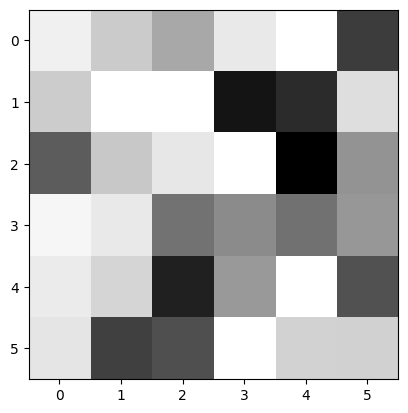

In [ ]:
plt.imshow(encoded_imgs[0].reshape(6,6), cmap=plt.cm.gray_r)    # ที่ Encode แล้ว

เมื่อพล็อตข้อมูลที่ผ่าน encoder แล้ว (พล็อต Latent vector หรือ encoded) จะได้รูปที่ดูไม่ออกว่าคืออะไร

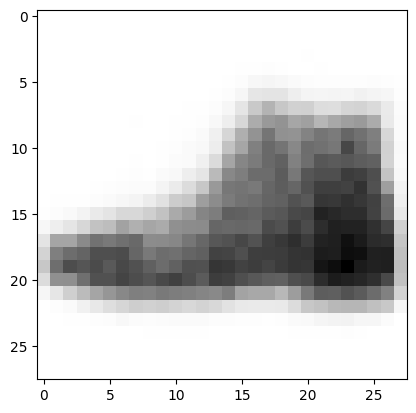

In [ ]:
plt.imshow(decoded_imgs[0], cmap=plt.cm.gray_r)    # ที่ Decode แล้ว

พล็อตเปรียบเทียบต้นฉบับ ที่ผ่านการ Encode และ Decode กลับ

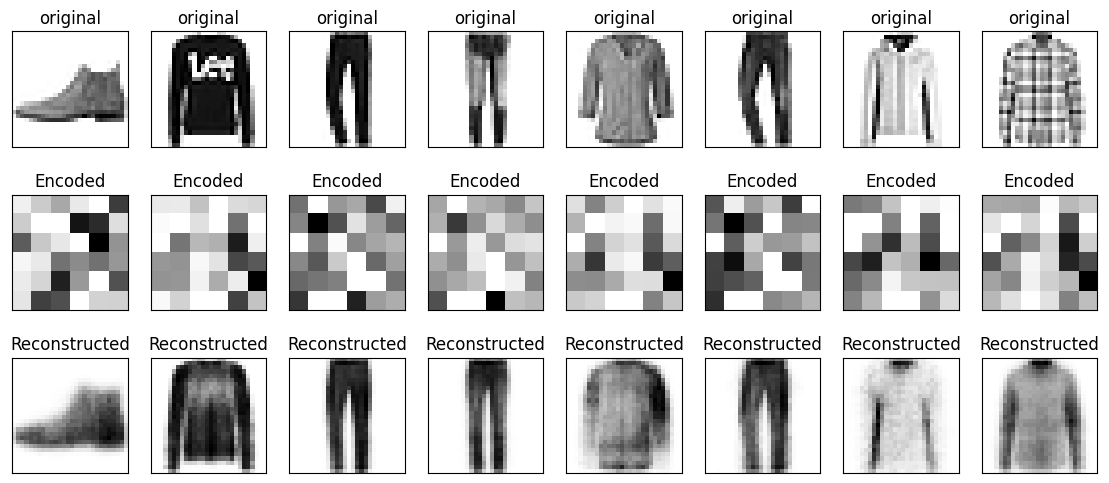

In [ ]:
n = 8
plt.figure(figsize=(14,6))    # กำหนดขนาดพล็อต
for i in range(n):
  # แสดง original
  ax = plt.subplot(3, n, i+1)
  plt.title("original")
  plt.imshow(X_test[i], cmap=plt.cm.gray_r)
  plt.xticks([]); plt.yticks([])

  # แสดงที่ผ่าน Encoder (Encoded หรือ Latent Vector)
  bx = plt.subplot(3, n, n+i+1)
  plt.title("Encoded")
  plt.imshow(encoded_imgs[i].reshape(6, 6), cmap=plt.cm.gray_r)   # 36 -> 6x6
  plt.xticks([]); plt.yticks([])

  # แสดงที่ผ่าน Decoder (Reconstruction) สร้างย้อนกลับ
  cx = plt.subplot(3, n, (2*n)+i+1)
  plt.title("Reconstructed")
  # plt.imshow(np.squeeze(decoded_imgs[i]), cmap=plt.cm.gray_r)
  plt.imshow(decoded_imgs[i], cmap=plt.cm.gray_r)
  plt.xticks([]); plt.yticks([])
plt.show()

### Latent vector
ในข้อนี้คือ vector ขนาด 36 เพื่อพล็อตเปรียบเทียบ จึงต้องปรับ Reshape ให้เป็น 6x6 อย่างไงก้ตาม เราสามารถกำหนดขนาดของ Latent vector (เปลี่ยนค่า encoding_dim)ได้ตามที่เราต้องการ เช่น encoding_dim=16 ต้อง .reshape(4, 4) เพื่อให้ตรงกับ 4x4=16 ซึ่งจะได้ภาพที่มีรายละเอียดลดลง เนื่องจากบีบข้อมูลลงมากนั้นเอง

เพราะขนาดของ Latent vector ที่น้อยไป จะทำให้ไม่สามารถเก็บค่าสำคัญของ Feature ได้เพียงพอ ทำให้ภาพที่ได้จาก Decoder มีรายละเอียดลดลง

# (2.) Autoencoder ลด Noise

workshop นี้แสดงการใช้ Autoencoder ทำการลด Noise ในภาพ (Denoise) ตัว Model ไม่ซับซ้อนมาก ใช้เวลา Train บน PC ไม่กี่วินาที

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras import Model, Sequential

## เตรียมข้อมูล

โหลดข้อมูลแล้วทำ Normalize และต่อด้วยการปรับขนาดมิติให้เป็น 3 มิติ เพื่อใช้กับ CNN (เดิมเป็น 28x28 ปรับให้เป็น 28x28x1) ดังนี้

In [ ]:
(X_train, _), (X_test, _) = fashion_mnist.load_data()
print(X_train.shape)    # ก่อนปรับมิติ

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = np.expand_dims(X_train, -1)   # ปรับมิติ
X_test = np.expand_dims(X_test, -1)

print(X_train.shape)    # หลังปรับมิติ

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000, 28, 28, 1)


จำลองใส่ Noise ลงในข้อมูล จะได้ข้อมูลที่เต็มไปด้วยจุด Noise (ตัวแปรที่เก็บข้อมูลมี Noise คือ X_.._noisy)

In [ ]:
noise_factor = 0.2
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0,
                                                          scale=1.0,
                                                          size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0,
                                                          scale=1.0,
                                                          size=X_test.shape)
# ใส่ Noise แล้ว

X_train_noisy = np.clip(X_train_noisy, 0., 1.)  # np.clip(a, a_min, a_max)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

print(X_train.shape)

(60000, 28, 28, 1)


หากต้องการพล็อตข้อมูลภาพที่ใส่ Noise แล้ว (ดูทีละภาพ)

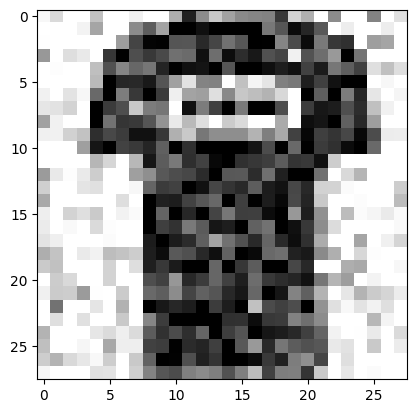

In [ ]:
img = X_train_noisy[1]
plt.imshow(img, cmap=plt.cm.gray_r)   # inverse
plt.show()

## สร้าง Model

ตัวอย่างนี้ใช้ CNN มีสถาปัตยกรรมและการ Train ดังนี้
- Encoder: ใช้ Conv2D มีชั้นลำดับคือ 28x28x1 -> 14x14x16 -> 7x7x8 (Latent)
- Decoder: ใช้ Conv2dTranspose รับ 7x7x8 แล้วขยายตามลำดับ -> 14x14x8 -> 28x28x16 สุดท้าย Dense -> 28x28x1

การ Train ในที่นี้จะใช้ข้อมูลที่มี Noise เป็น X แล้วใช้ X ที่ไม่มี Noise เป็น y เพื่อสอนเครื่องว่า input แบบไหน แล้วต้องการ output เป้นแบบไหน (ทำภาพที่ไม่ชัด ให้ชัด)

In [ ]:
from tensorflow.keras.layers import InputLayer, Conv2D, Conv2DTranspose
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = Sequential([
        # InputLayer(input_shape=(28, 28, 1))    # ไม่มีบรรทัดนี้ก็ได้
        Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
        Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = Sequential([
        Conv2DTranspose(8, kernel_size=3, strides=2,
                        activation='relu', padding='same'),
        Conv2DTranspose(16, kernel_size=3, strides=2,
                        activation='relu', padding='same'),
        Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()    # Instantiate สร้าง Model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train_noisy, X_train, epochs=10, batch_size=128,
                validation_data=(X_test, X_test))

Epoch 1/10
469/469 [==============================] - 88s 183ms/step - loss: 0.3588 - val_loss: 0.2908
Epoch 2/10
469/469 [==============================] - 76s 163ms/step - loss: 0.2830 - val_loss: 0.2813
Epoch 3/10
469/469 [==============================] - 84s 179ms/step - loss: 0.2785 - val_loss: 0.2793
Epoch 4/10
469/469 [==============================] - 71s 151ms/step - loss: 0.2761 - val_loss: 0.2756
Epoch 5/10
469/469 [==============================] - 64s 136ms/step - loss: 0.2745 - val_loss: 0.2758
Epoch 6/10
469/469 [==============================] - 63s 134ms/step - loss: 0.2733 - val_loss: 0.2745
Epoch 7/10
469/469 [==============================] - 58s 125ms/step - loss: 0.2721 - val_loss: 0.2752
Epoch 8/10
469/469 [==============================] - 70s 149ms/step - loss: 0.2713 - val_loss: 0.2736
Epoch 9/10
469/469 [==============================] - 74s 157ms/step - loss: 0.2706 - val_loss: 0.2718
Epoch 10/10
469/469 [==============================] - 88s 187ms/step - l

## ใช้งาน

การใช้งาน ป้อนอินพุตภาพที่มี Noise เข้าสู่ Autoencoder (ใช้ X_test_noisy จำนวนทดสอบ 10000 ภาพ ที่ตัวระบบยังไม่เคยเห็นมาก่อน) คล้ายกับ workshop ที่ผ่านมา คือ Encoder ก่อน แล้วต่อด้วย Decoder

In [ ]:
encoded_imgs = autoencoder.encoder(X_test_noisy).numpy()    # Encode
print(encoded_imgs.shape)
print(type(encoded_imgs))

decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()    # Decode
print(decoded_imgs.shape)

(10000, 7, 7, 8)
<class 'numpy.ndarray'>
(10000, 28, 28, 1)


พล็อตเปรียบเทียบระหว่างก่อนและหลังลด Noise จะเห็นว่า autoencoder ลด Noise ลงได้จนแทบไม่เหลือ

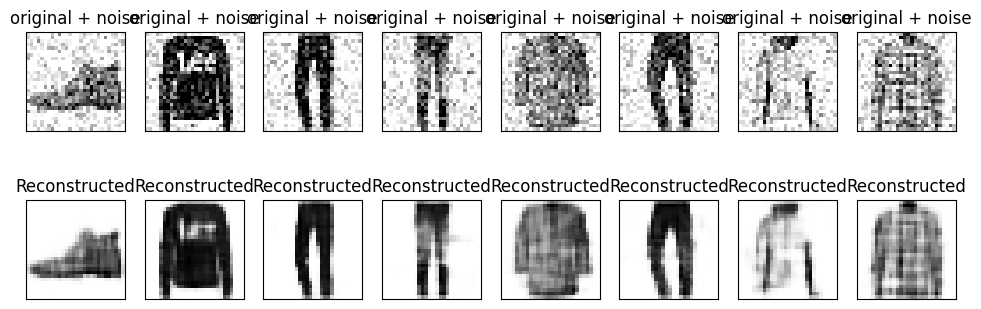

In [ ]:
n = 8
plt.figure(figsize=(12,4))    # กำหนดขนาดพล็อต
for i in range(n):
  # original + noise
  ax = plt.subplot(2, n, i+1)
  plt.title("original + noise")
  plt.imshow(np.squeeze(X_test_noisy[i]), cmap=plt.cm.gray_r)
  plt.imshow(X_test_noisy[i], cmap=plt.cm.gray_r)
  plt.xticks([]); plt.yticks([])

  # ลด Noise (Reconstruction)
  bx = plt.subplot(2, n, i+n+1)
  plt.title("Reconstructed")
  plt.imshow(np.squeeze(decoded_imgs[i]), cmap=plt.cm.gray_r)
  plt.xticks([]); plt.yticks([])
plt.show()

# (3.) ลด Noise พื้นหลังข้อความ

ข้อนี้แสดงการใช้ Autoencoder ลด Noise ของ ภาพที่เป็นข้อความ (Text) ลักษณะกำจัดพื้นหลัง ให้เคลียร์ชัดเจนขึ้น โดยสามารถกำจัดพื้นหลังที่เป็นรอยเลอะเทอะ หรือรอยยับของกรดาษลง

## เตรียมความพร้อม

ชุดข้อมูล ดาวน์โหลดจาก [ที่นี่](https://www.kaggle.com/c/denoising-dirty-documents/data) ปรกอบไปด้วยโฟลเดอร์ย่อย ดังนี้
- train: ภาพข้อความที่มี Noise จำนวน 144 ภาพ
- train_cleaned: ภาพของ train ที่ไม่มี Noise ตามหลักการคือ ใช้ train เป็น X แล้วใช้ train_cleaned เป็น y การจับคู่ซื่อไฟล์ภาพต้องตรงกัน เช่น มี train/107.png ที่มี Noise ก็ต้องมี train_cleaned/107.png ที่เป็นภาพข้อความเดียวกัน แต่ไม่มี Noise เพื่อสอนเครื่องว่าอินพุตแบบไหน แล้วต้องการเอาต์พุตแบบไหน
- test: ภาพที่มีข้อความ Noise สำหรับทดสอบการลด Noise (เป็นภาพที่โมเดลไม่เคยเห็นมาก่อน) จำนวน 72 ภาพ

ตัวโมเดลไม่ซับซ้อนมาก แต่มิติอินพุตขนาด 540x420 ซึ่งใช้เวลา Train ประมาณ 3 นาที บน Colab แต่บน PC ใช้เวลาประมาณ 1.5 ชั่วโมง จึงแนะนำให้ใช้ Colab

จัดเก็บโฟลเดอร์ของข้อมูลที่โหลดมาแล้วดังรูป

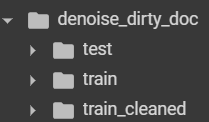

workshop นี้ใช้ tqdm เพื่อแสดงแถบ % ความคืบหน้าในการรัน (Colab ติดตั้งให้อยู่แล้ว)

## โหลดข้อมูล

เริ่มต้น อิมพอร์ตไลบารี และอ่านข้อมูลเข้าสู่ระบบ

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm   # สำหรับแสดงแถบ % การทำงาน (Progress bar)

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array   # โหลดภาพ
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (InputLayer, Conv2D,
                                     Dropout, Conv2DTranspose)
from tensorflow.keras.callbacks import EarlyStopping

path = '/content/drive/MyDrive/deep_greenbook/datasets/denoise_dirty_doc'

ตั้งค่าขนาดภาพให้กับ Model เนื่องจากภาพมีขนาดใหญ่ แนะนำทางเลือก ดังนี้
- ภาพขนาดใหญ่: การใช้ภาพขนาดใหญ่ มีข้อดีคือการลด Noise จะได้ข้อความที่ชัดเจนดี แต่การ train และประมวลผลจะใช้เวลา Train นาน แนะนำให้ใช้ GPU ของ Colab

In [2]:
imgW, imgH = 540, 420

- ภาพขนาดปานกลางหรือเล็ก: การใช้ภาพขนาดเล็กลง มีข้อดีคือใช้เวลาประมวลสั้นลง แต่จะได้ความชัดเจนของข้อความลดลง เหมาะสำหรับ ทดลองบน PC เพื่อดูผลลัพธ์รวมๆ

In [ ]:
# imgW, imgH = 300, 240     # เลือกขนาดใดก็ได้
# imgW, imgH = 420, 320

เก็บชื่อไฟล์ภาพไว้ใน List แล้วนับจำนวน จะได้ว่ามี train 144 ไฟล์ และ test 72 ไฟล์

In [3]:
train_img = sorted(os.listdir(path + '/train'))     # โฟลเดอร์ train
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))     # โฟลเดอร์ train_cleaned
test_img = sorted(os.listdir(path + '/test'))     # โฟลเดอร์ test

print(f'X Train: {len(train_img)}, Y Train: {len(train_cleaned_img)}')
print(f'X Test:', len(test_img))
train_img[:5]

X Train: 144, Y Train: 144
X Test: 72


['101.png', '102.png', '104.png', '105.png', '107.png']

ตรวจสอบขนาดภาพลำดับ Index 0

In [5]:
img = load_img(path+'/train/'+train_img[0],
               target_size=(imgW, imgH),
               color_mode='grayscale')
print(img_to_array(img).shape)    # ภาพ 1 Channel (โทนเทา)

(540, 420, 1)


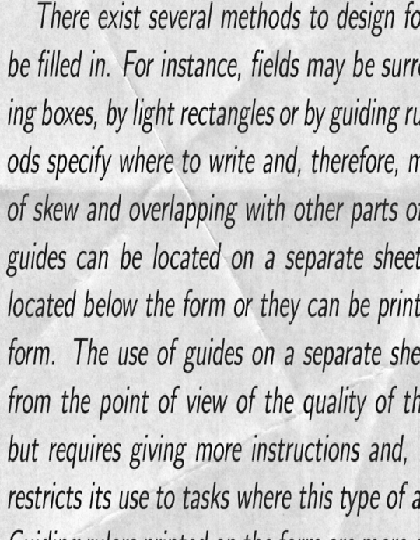

In [6]:
img

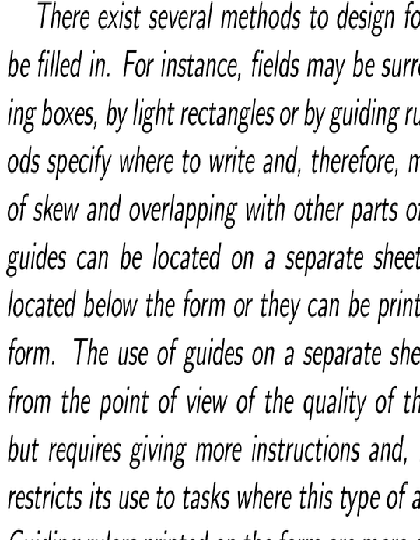

In [8]:
img = load_img(path+'/train_cleaned/'+train_cleaned_img[0],
               target_size=(imgW, imgH))
img

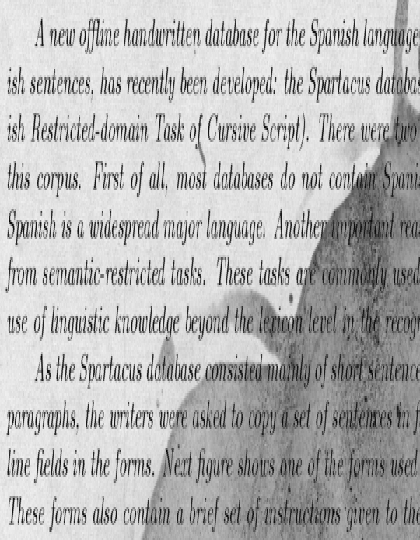

In [10]:
img = load_img(path+'/test/'+test_img[0],
               target_size=(imgW, imgH))
img

## ตรวจสอบข้อมูลเบื้องต้น (Preprocess)

สร้างฟังก์ชันสำหรับประมวลผลภาพ (Preprocess) โดยจะทำหน้าที่อ่านข้อมุลภาพในโหมดโทนเทา (grayscale) -> แปลงเป็น Array -> ทำ Normalize

In [7]:
def process_image(file):
  img = load_img(file, target_size=(imgW, imgH), color_mode='grayscale')
  img = img_to_array(img)   # convert image to array
  img = img/255.0   # Normalize
  return img

ทำการอ่านภาพ และประมวลผลภาพ Train, Test

In [14]:
train_cleaned_img[:5]

['101.png', '102.png', '104.png', '105.png', '107.png']

In [20]:
train = []
train_cleaned = []
test = []

for f in tqdm(train_img):
  train.append(process_image(path + '/train/' + f))     # train

for f in tqdm(train_cleaned_img):
  train_cleaned.append(process_image(path + '/train_cleaned/' + f))     # train_cleaned

for f in tqdm(test_img):
  test.append(process_image(path + '/test/' + f))     # test

print()
print('Train0 shape:', train[0].shape)
print('TrainCleaned0 shape:', train_cleaned[0].shape)
print('Test0 shape:', test[0].shape)

100%|██████████| 72/72 [00:15<00:00,  4.67it/s]


Train0 shape: (540, 420, 1)
TrainCleaned0 shape: (540, 420, 1)
Test0 shape: (540, 420, 1)


พล็อตดู train และ train_cleaned

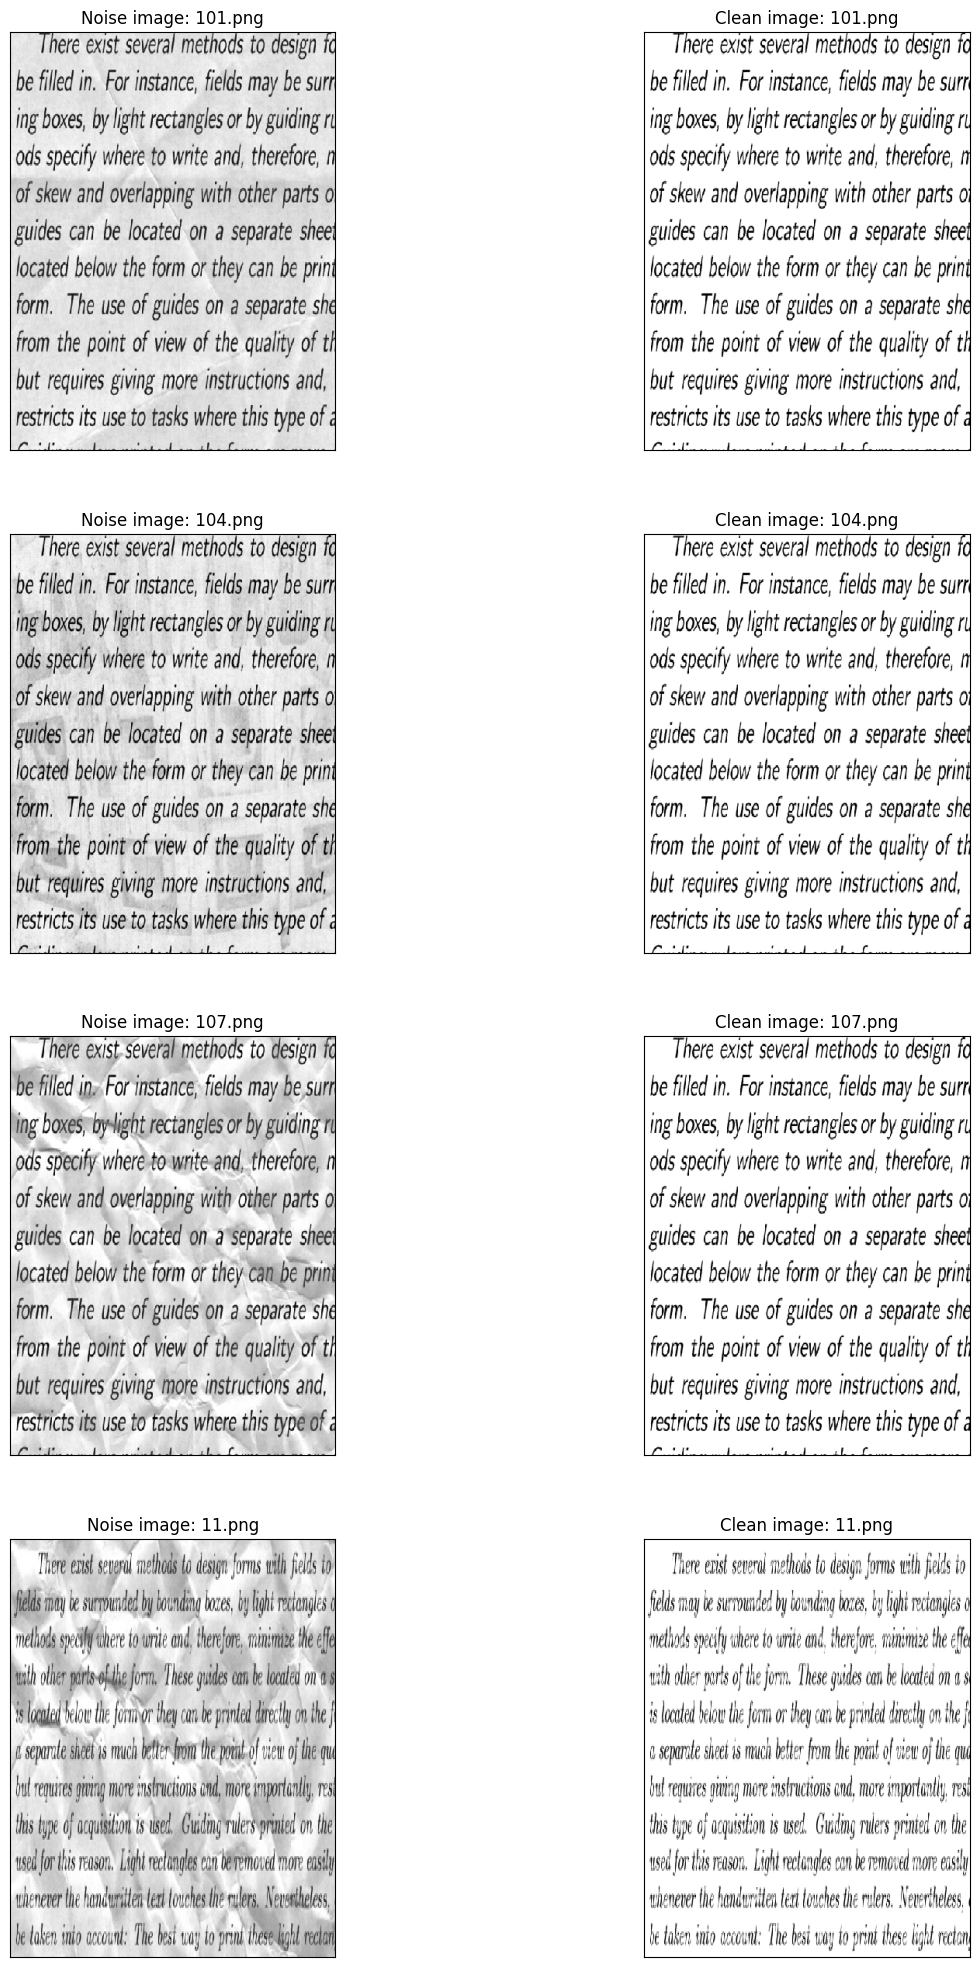

In [21]:
plt.figure(figsize=(15, 25))
for i in range(0, 8, 2):
  plt.subplot(4,2,i+1)
  plt.xticks([]); plt.yticks([])
  plt.imshow(train[i][:,:,0], cmap='gray')
  # plt.imshow(train[i], cmap='gray')
  plt.title('Noise image: {}'.format(train_img[i]))

  plt.subplot(4,2,i+2)
  plt.xticks([]); plt.yticks([])
  plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
  # plt.imshow(train_cleaned[i], cmap='gray')
  plt.title('Clean image: {}'.format(train_img[i]))
plt.show()

## เตรียมข้อมูล Train และ Validate


ทำการแบ่งข้อมูล เพื่อใช้เป็นตัว Train (X_train) และ Validate (X_val) โดยในที่นี้แบ่งชุด train ออกมา 15% สำหรับ Validate ส่วน y_train คือ ข้อมูลภาพจาก train_cleaned

In [22]:
# เปลี่ยนจาก List เป็น Numpy array แล้วแบ่งด้วย train_test_split
X_train = np.asarray(train)
y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)
X_train.shape, X_val.shape

((122, 540, 420, 1), (22, 540, 420, 1))

X_train มีจำนวน 122 sample ส่วน X_test มี 22 sample

## สร้าง Model

ตัวอย่างนี้ใช้ CNN มีสถาปัตยกรรมคล้ายกับ Workshop 2 แต่ขนาดอินพุตภาพแตกต่างกัน สรุปขนาดแต่ละขั้นตอน ดังนี้
- Encoder: ใช้ Conv2D มีขั้นลำดับคือ 420x540x1 -> 210x270x64 -> 105x135x128 (Latent)
- Decoder: ใช้ Conv2dTranspose (ทำงานในลักษณะขยาย) รับ 105x135x128 แล้ว ขยายตามลำดับ -> 210x270x128 -> 420x540x64 -> 420x540x1 (Dense)

การ Train ในที่นี้จะใช้ข้อมูลที่มี Noise เป็น X แล้วใช้ X ที่ไม่มี Noise เป็น y เพื่อสอนเครื่องว่าอินพุตแบบไหน แล้วต้องการเอาต์พุตเป็นแบบไหน (ทำภาพไม่ชัด ให้ชัด)

In [25]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = Sequential([   # Encoder
        # InputLayer(input_shape=(imgW, imgH, 1))    # ไม่มีบรรทัดนี้ก็ได้
        Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
        Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
        Dropout(0.4)])

    self.decoder = Sequential([   # Decoder
        Conv2DTranspose(128, kernel_size=3, strides=2,
                        activation='relu', padding='same'),
        Conv2DTranspose(64, kernel_size=3, strides=2,
                        activation='relu', padding='same'),
        Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()    # Instantiate สร้าง Model

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
callback = EarlyStopping(monitor='loss', patience=20)
history = autoencoder.fit(X_train, y_train, epochs=100, batch_size=16,
                validation_data=(X_val, y_val), verbose=1, callbacks=[callback])

Epoch 1/100
8/8 [==============================] - 29s 2s/step - loss: 0.5839 - val_loss: 0.3305
Epoch 2/100
8/8 [==============================] - 4s 530ms/step - loss: 0.3574 - val_loss: 0.3295
Epoch 3/100
8/8 [==============================] - 4s 516ms/step - loss: 0.3306 - val_loss: 0.3110
Epoch 4/100
8/8 [==============================] - 4s 515ms/step - loss: 0.3059 - val_loss: 0.2961
Epoch 5/100
8/8 [==============================] - 4s 534ms/step - loss: 0.2781 - val_loss: 0.2575
Epoch 6/100
8/8 [==============================] - 4s 516ms/step - loss: 0.2449 - val_loss: 0.2302
Epoch 7/100
8/8 [==============================] - 4s 526ms/step - loss: 0.2257 - val_loss: 0.2182
Epoch 8/100
8/8 [==============================] - 4s 532ms/step - loss: 0.2140 - val_loss: 0.2037
Epoch 9/100
8/8 [==============================] - 4s 535ms/step - loss: 0.1997 - val_loss: 0.1907
Epoch 10/100
8/8 [==============================] - 4s 526ms/step - loss: 0.1853 - val_loss: 0.1748
Epoch 11/10

In [26]:
autoencoder.encoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 270, 210, 64)      640       
                                                                 
 conv2d_7 (Conv2D)           (None, 135, 105, 128)     73856     
                                                                 
 dropout_2 (Dropout)         (None, 135, 105, 128)     0         
                                                                 
Total params: 74496 (291.00 KB)
Trainable params: 74496 (291.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
autoencoder.decoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_4 (Conv2D  (None, 270, 210, 128)     147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 540, 420, 64)      73792     
 Transpose)                                                      
                                                                 
 conv2d_8 (Conv2D)           (None, 540, 420, 1)       577       
                                                                 
Total params: 221953 (867.00 KB)
Trainable params: 221953 (867.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


พล็อต loss

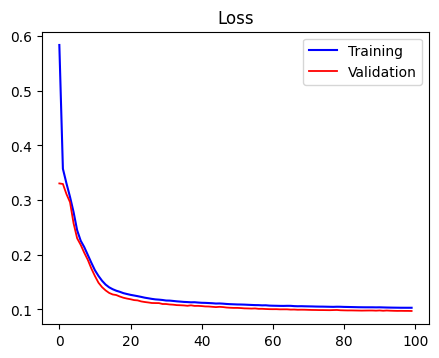

In [28]:
plt.figure(figsize=(5, 3.8))
plt.plot(history.history['loss'], color='b', label='Training')
plt.plot(history.history['val_loss'], 'r', lw=1.3, label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

## ใช้งาน

In [29]:
Y_pred = autoencoder.predict(X_test, batch_size=16)

5/5 [==============================] - 3s 663ms/step


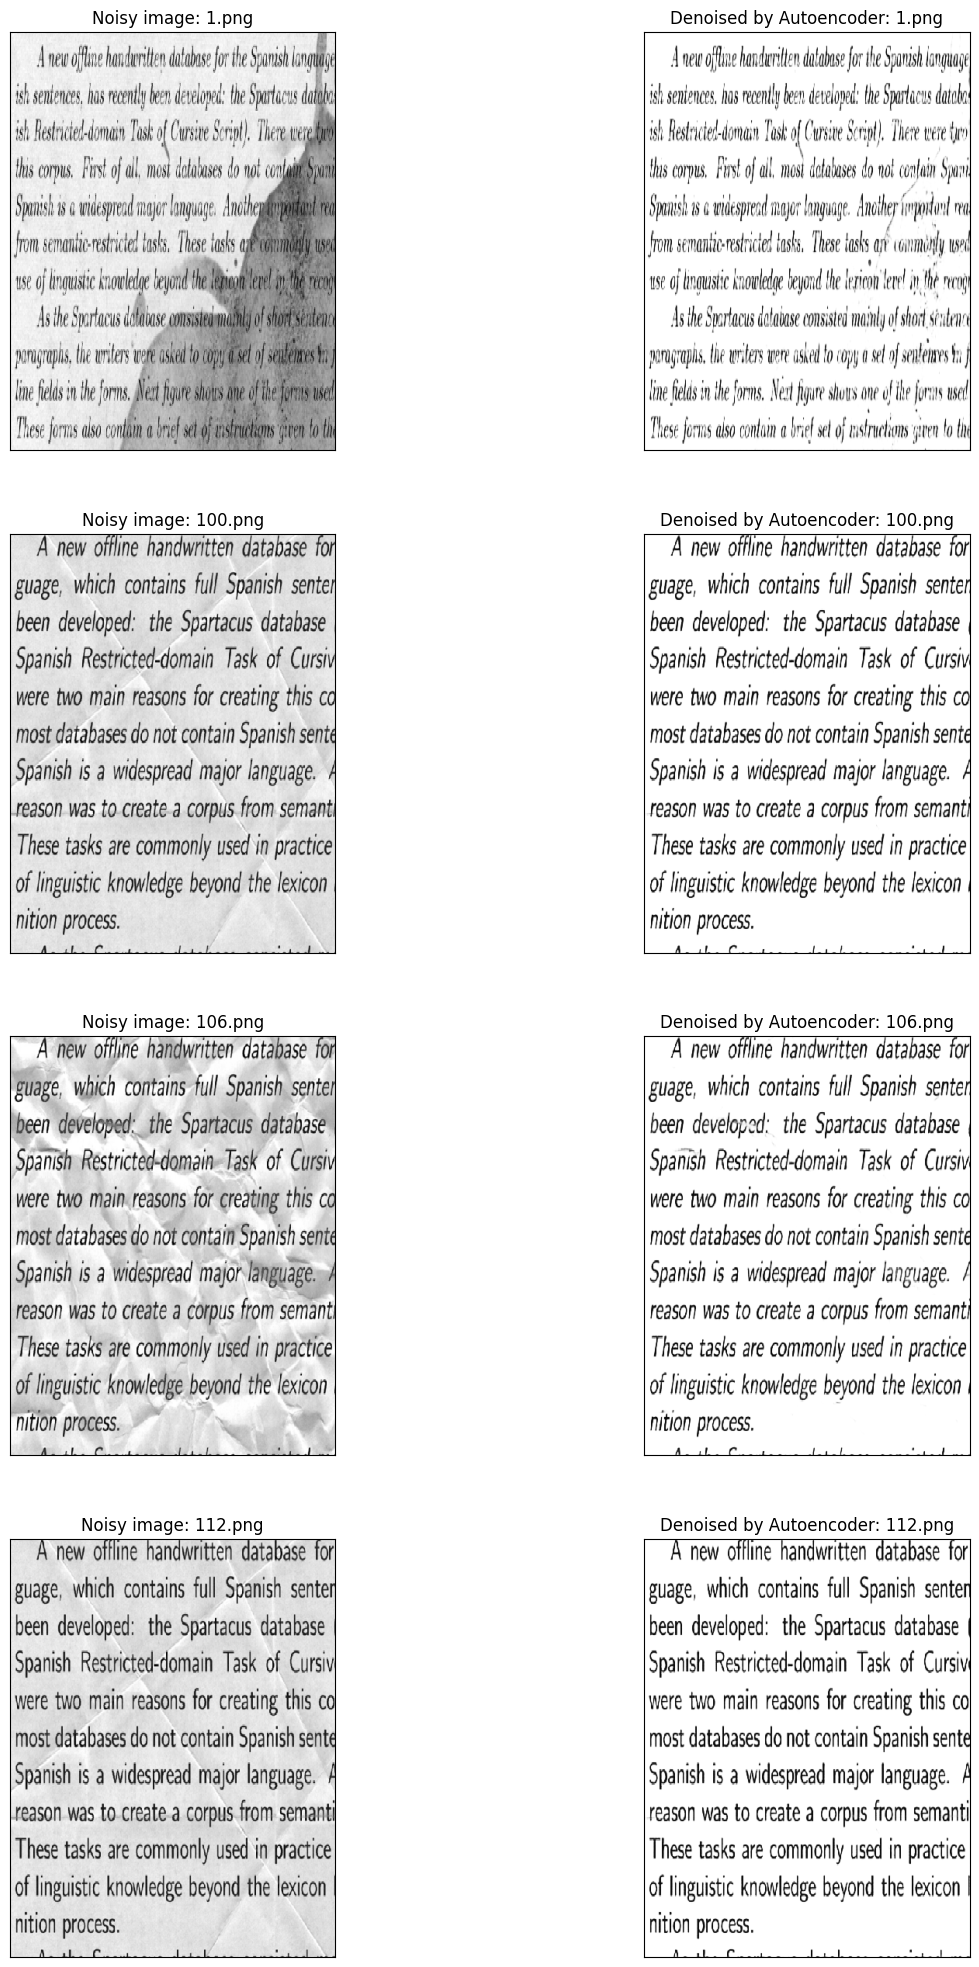

In [30]:
plt.figure(figsize=(15, 25))
for i in range(0, 8, 2):
  plt.subplot(4,2,i+1)
  plt.xticks([]); plt.yticks([])
  plt.imshow(X_test[i][:,:,0], cmap='gray')
  plt.title('Noisy image: {}'.format(test_img[i]))

  plt.subplot(4,2,i+2)
  plt.xticks([]); plt.yticks([])
  plt.imshow(Y_pred[i][:,:,0], cmap='gray')
  plt.title('Denoised by Autoencoder: {}'.format(test_img[i]))
plt.show()

## สรุป

Autoencoder เครือข่าย Neural Network หรือ CNN ทำหน้าที่เข้ารหัสหรือบีบอัดข้อมูลให้มีขนาดเล็กลง จากนั้นก็ทำการถอดรหัสขยายกลับใหมีขนาดเท่าเดม ประกอบด้วยส่วนหลัก 2 ส่วน คือ **Encoder** ทำหน้าที่เข้ารหัสข้อมูลอินพุต และ **Decoder** ทำหน้าที่ถอดรหัสให้ได้ข้อมูลมิติเท่ากับอินพุตต้นฉบับ โดยจะทำงานต่อกัน คือเอาต์พุตของ Encoder จะใช้เป็นอินพุตเข้าสู่ Decoder จนได้เอาต์พุตสุดท้ายออกมา ซึ่งเอาต์พุตสุดท้ายมีมิติเท่ากับอินพุตต้นฉบับก็จริง แต่ค่าของข้อมูลที่ได้จะไม่เท่ากับต้นฉบับ เช่น ถ้าอินพุตเป็นภาพ ก็จะได้ภาพที่มีเค้าโครงเดิม แต่รายละเอียดภายในไม่คมชัดเท่าเดิม

หน้าที่ของ Encoder จะคล้ายกับ Principal Component Analysis (PCA) แต่ PCA เป็นแบบ Linear ส่วน Autoencoder เป็นแบบ Non-linear ตัวอย่างการใช้งาน Autoencoder เช่น
- ใช้ลด Noise หรือสัญญาณรบกวนออกจากข้อมูลภาพ เสียง ฯลฯ
- ใช้ตรวจจับหรือลดความผิดปกติของข้อมูล (Anormaly Detection)
- ลดมิติ Feature (Dimensionality reduction)

บทนี้ใช้ Autoencoder ลด Noise พื้นหลังรูปภาพที่เป็นข้อความ